# 分子动力学
---

分子动力学是一套分子模拟方法，该方法主要是依靠计算机来模拟分子、原子体系的运动，是一种多体模拟方法。通过对分子、原子在一定时间内运动状态的模拟，从而以动态观点考察系统随时间演化的行为。通常，分子、原子的轨迹是通过数值求解牛顿运动方程得到，势能（或其对笛卡尔坐标的一阶偏导数，即力）通常可以由分子间相互作用势能函数、分子力学力场、全始计算给出。对于考虑分子本身的量子效应的体系，往往采用波包近似处理或采用量子力学的费恩曼路径积分表述方式[1]处理。 分子动力学也常常被采用作为研究复杂体系热力学性质的采样方法。在分子体系的不同状态构成的系综中抽取样本，从而计算体系的构型积分，并以构型积分的结果为基础进一步计算体系的热力学量和其他宏观性质。 分子动力学最早在20世纪50年代由物理学家提出，如今广泛应用于物理、化学、生物体系的理论研究中。 

## 分子热运动
---
![](./Images/Translational_motion.gif)

上图为一个分子系统热运动的模拟动画。其中一些小球被涂成了红色方便追踪。在这个模拟中，平均而言，两个分子碰撞前后动能保持不变。同时，我们忽视了黑体辐射，即系统的总能量保持不变。

## 理想气体模型
---

### 弹性碰撞


液体或者气体中分子之间发生的碰撞并不是完美的[弹性碰撞](https://en.wikipedia.org/wiki/Elastic_collision)。因为在碰撞的过程中，分子的平动会和其他运动自由度之间发生能量交换。但是平均而言，分子间的碰撞可以被简化为弹性碰撞，即分子间只发生平动动能交换。

我们考虑如下一个简化系统作为分子热运动的近似。
1. 分子抽象为一个具有质量m和直径r的圆球。
2. 分子间的相互作用力暂时被忽略。
3. 当两个分子接触时，发生完全弹性碰撞。

### 二维分子体系的弹性碰撞

![](./Images/Elastic_collision.jpg)

为了方便理解和作图，我们这里对二维情况下的弹性碰撞进行计算。对于两个无旋转的刚体而言，发生弹性碰撞时遵从动量守恒，能量守恒和角动量守恒。如果二者之间没有摩擦力，则二者速度在碰撞点切线方向上保持不变，碰撞只改变速度在垂直切线上的分量。

碰撞之后二者速度的表达式为：
$$\begin{align}
\mathbf{v}'_1&=\mathbf{v}_1-\frac{2 m_2}{m_1+m_2} \ \frac{\langle \mathbf{v}_1-\mathbf{v}_2,\,\mathbf{x}_1-\mathbf{x}_2\rangle}{\|\mathbf{x}_1-\mathbf{x}_2\|^2} \ (\mathbf{x}_1-\mathbf{x}_2),
\\
\mathbf{v}'_2&=\mathbf{v}_2-\frac{2 m_1}{m_1+m_2} \ \frac{\langle \mathbf{v}_2-\mathbf{v}_1,\,\mathbf{x}_2-\mathbf{x}_1\rangle}{\|\mathbf{x}_2-\mathbf{x}_1\|^2} \ (\mathbf{x}_2-\mathbf{x}_1)
\end{align}$$
上式中括号表示两个矢量的内积或者点乘。

### 二维分子体系的计算模拟

这里设置如下初始条件：
1. 所有分子的初始位置为*随机值*
2. 所有分子的初始速率相同，速度方向为*随机值*

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
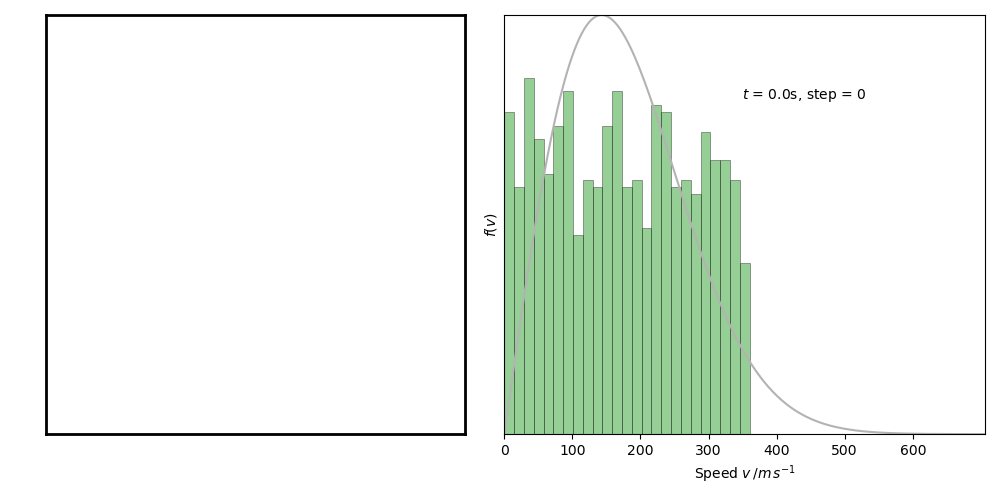

In [1]:
%matplotlib widget

import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
from matplotlib.animation import FuncAnimation

X, Y = 0, 1
class MDSimulation:

    def __init__(self, pos, vel, r, m):
        """
        Initialize the simulation with identical, circular particles of radius
        r and mass m. The n x 2 state arrays pos and vel hold the n particles'
        positions in their rows as (x_i, y_i) and (vx_i, vy_i).

        """

        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.n = self.pos.shape[0]
        self.r = r
        self.m = m
        self.nsteps = 0

    def advance(self, dt):
        """Advance the simulation by dt seconds."""

        self.nsteps += 1
        # Update the particles' positions according to their velocities.
        self.pos += self.vel * dt
        # Find indices for all unique collisions.
        dist = squareform(pdist(self.pos))
        iarr, jarr = np.where(dist < 2 * self.r)
        k = iarr < jarr
        iarr, jarr = iarr[k], jarr[k]

        # For each collision, update the velocities of the particles involved.
        for i, j in zip(iarr, jarr):
            pos_i, vel_i = self.pos[i], self.vel[i]
            pos_j, vel_j =  self.pos[j], self.vel[j]
            rel_pos, rel_vel = pos_i - pos_j, vel_i - vel_j
            r_rel = rel_pos @ rel_pos
            v_rel = rel_vel @ rel_pos
            v_rel = 2 * rel_pos * v_rel / r_rel - rel_vel
            v_cm = (vel_i + vel_j) / 2
            self.vel[i] = v_cm - v_rel/2
            self.vel[j] = v_cm + v_rel/2

        # Bounce the particles off the walls where necessary, by reflecting
        # their velocity vectors.
        hit_left_wall = self.pos[:, X] < self.r
        hit_right_wall = self.pos[:, X] > 1 - self.r
        hit_bottom_wall = self.pos[:, Y] < self.r
        hit_top_wall = self.pos[:, Y] > 1 - self.r
        self.vel[hit_left_wall | hit_right_wall, X] *= -1
        self.vel[hit_bottom_wall | hit_top_wall, Y] *= -1

# Number of particles.
n = 1000
# Scaling factor for distance, m-1. The box dimension is therefore 1/rscale.
rscale = 5.e6
# Use the van der Waals radius of Ar, about 0.2 nm.
r = 2e-10 * rscale
# Scale time by this factor, in s-1.
tscale = 1e9    # i.e. time will be measured in nanoseconds.
# Take the mean speed to be the root-mean-square velocity of Ar at 300 K.
sbar = 353 * rscale / tscale
# Time step in scaled time units.
FPS = 30
dt = 1/FPS
# Particle masses, scaled by some factor we're not using yet.
m = 1

# Initialize the particles' positions randomly.
pos = np.random.random((n, 2))
# Initialize the particles velocities with random orientations and random
# magnitudes  around the mean speed, sbar.
theta = np.random.random(n) * 2 * np.pi
s0 = sbar * np.random.random(n)
vel = (s0 * np.array((np.cos(theta), np.sin(theta)))).T

sim = MDSimulation(pos, vel, r, m)

# Set up the Figure and make some adjustments to improve its appearance.
DPI = 100
width, height = 1000, 500
fig = plt.figure(figsize=(width/DPI, height/DPI), dpi=DPI)
fig.subplots_adjust(left=0, right=0.97)
sim_ax = fig.add_subplot(121, aspect='equal', autoscale_on=False)
sim_ax.set_xticks([])
sim_ax.set_yticks([])
# Make the box walls a bit more substantial.
for spine in sim_ax.spines.values():
    spine.set_linewidth(2)

speed_ax = fig.add_subplot(122)
speed_ax.set_xlabel('Speed $v\,/m\,s^{-1}$')
speed_ax.set_ylabel('$f(v)$')

particles, = sim_ax.plot([], [], 'ko')

class Histogram:
    """A class to draw a Matplotlib histogram as a collection of Patches."""

    def __init__(self, data, xmax, nbars, density=False):
        """Initialize the histogram from the data and requested bins."""
        self.nbars = nbars
        self.density = density
        self.bins = np.linspace(0, xmax, nbars)
        self.hist, bins = np.histogram(data, self.bins, density=density)

        # Drawing the histogram with Matplotlib patches owes a lot to
        # https://matplotlib.org/3.1.1/gallery/animation/animated_histogram.html
        # Get the corners of the rectangles for the histogram.
        self.left = np.array(bins[:-1])
        self.right = np.array(bins[1:])
        self.bottom = np.zeros(len(self.left))
        self.top = self.bottom + self.hist
        nrects = len(self.left)
        self.nverts = nrects * 5
        self.verts = np.zeros((self.nverts, 2))
        self.verts[0::5, 0] = self.left
        self.verts[0::5, 1] = self.bottom
        self.verts[1::5, 0] = self.left
        self.verts[1::5, 1] = self.top
        self.verts[2::5, 0] = self.right
        self.verts[2::5, 1] = self.top
        self.verts[3::5, 0] = self.right
        self.verts[3::5, 1] = self.bottom

    def draw(self, ax):
        """Draw the histogram by adding appropriate patches to Axes ax."""
        codes = np.ones(self.nverts, int) * path.Path.LINETO
        codes[0::5] = path.Path.MOVETO
        codes[4::5] = path.Path.CLOSEPOLY
        barpath = path.Path(self.verts, codes)
        self.patch = patches.PathPatch(barpath, fc='tab:green', ec='k',
                                  lw=0.5, alpha=0.5)
        ax.add_patch(self.patch)

    def update(self, data):
        """Update the rectangle vertices using a new histogram from data."""
        self.hist, bins = np.histogram(data, self.bins, density=self.density)
        self.top = self.bottom + self.hist
        self.verts[1::5, 1] = self.top
        self.verts[2::5, 1] = self.top


def get_speeds(vel):
    """Return the magnitude of the (n,2) array of velocities, vel."""
    return np.hypot(vel[:, X], vel[:, Y])

def get_KE(speeds):
    """Return the total kinetic energy of all particles in scaled units."""
    return 0.5 * sim.m * sum(speeds**2)

speeds = get_speeds(sim.vel)
speed_hist = Histogram(speeds, 2 * sbar, 50, density=True)
speed_hist.draw(speed_ax)
speed_ax.set_xlim(speed_hist.left[0], speed_hist.right[-1])
# TODO don't hardcode the upper limit for the histogram speed axis.
ticks = np.linspace(0, 600, 7, dtype=int)
speed_ax.set_xticks(ticks * rscale/tscale)
speed_ax.set_xticklabels([str(tick) for tick in ticks])
speed_ax.set_yticks([])

fig.tight_layout()

# The 2D Maxwell-Boltzmann equilibrium distribution of speeds.
mean_KE = get_KE(speeds) / n
a = sim.m / 2 / mean_KE
# Use a high-resolution grid of speed points so that the exact distribution
# looks smooth.
sgrid_hi = np.linspace(0, speed_hist.bins[-1], 200)
f = 2 * a * sgrid_hi * np.exp(-a * sgrid_hi**2)
mb_line, = speed_ax.plot(sgrid_hi, f, c='0.7')
# Maximum value of the 2D Maxwell-Boltzmann speed distribution.
fmax = np.sqrt(sim.m / mean_KE / np.e)
speed_ax.set_ylim(0, fmax)

# For the distribution derived by averaging, take the abcissa speed points from
# the centre of the histogram bars.
sgrid = (speed_hist.bins[1:] + speed_hist.bins[:-1]) / 2
mb_est_line, = speed_ax.plot([], [], c='r')
mb_est = np.zeros(len(sgrid))

# A text label indicating the time and step number for each animation frame.
xlabel, ylabel = sgrid[-1] / 2, 0.8 * fmax
label = speed_ax.text(xlabel, ylabel, '$t$ = {:.1f}s, step = {:d}'.format(0, 0),
                      backgroundcolor='w')

def init_anim():
    """Initialize the animation"""
    particles.set_data([], [])

    return particles, speed_hist.patch, mb_est_line, label

def animate(i):
    """Advance the animation by one step and update the frame."""
    global sim, verts, mb_est_line, mb_est
    sim.advance(dt)

    particles.set_data(sim.pos[:, X], sim.pos[:, Y])
    particles.set_markersize(0.5)

    speeds = get_speeds(sim.vel)
    speed_hist.update(speeds)

    # Once the simulation has approached equilibrium a bit, start averaging
    # the speed distribution to indicate the approximation to the Maxwell-
    # Boltzmann distribution.
    if i >= IAV_START:
        mb_est += (speed_hist.hist - mb_est) / (i - IAV_START + 1)
        mb_est_line.set_data(sgrid, mb_est)

    label.set_text('$t$ = {:.1f} ns, step = {:d}'.format(i*dt, i))

    return particles, speed_hist.patch, mb_est_line, label

# Only start averaging the speed distribution after frame number IAV_ST.
IAV_START = 200
# Number of frames; set to None to run until explicitly quit.
frames = 1000
anim = FuncAnimation(fig, animate, frames=frames, interval=10, blit=False,
                    init_func=init_anim)

plt.show()


经过一定时间演化，速率分布变化逐步减小，达到平衡状态。其中灰线为二维情况下Maxwell-Boltzmann速率分布函数：
$$f(v) = \frac{mv}{k_\mathrm{B}T}\exp\left(-\frac{mv^2}{2k_\mathrm{B}T}\right)$$